**Import the Libraries**

In [1]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional
print(tf.__version__)

2.2.0


**Get the Data**

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv \
    -O /tmp/bbc-text.csv

--2020-06-09 02:48:01--  https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.128, 2a00:1450:4013:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [text/csv]
Saving to: ‘/tmp/bbc-text.csv’

/tmp/bbc-text.csv   100%[===================>]   4.82M  --.-KB/s    in 0.02s   

2020-06-09 02:48:02 (273 MB/s) - ‘/tmp/bbc-text.csv’ saved [5057493/5057493]



**Import NTLK Library**

In [3]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Set the Hyper-Parameters**

In [0]:
vocab_size = 5000 
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' #OOV = Out of Vocabulary
training_portion = .8

**Populate List and Remove the Stopwords**

In [5]:
articles = []
labels = []

with open("/tmp/bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        article = row[1]
        for word in STOPWORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
            article = article.replace(' ', ' ')
        articles.append(article)
print(len(labels))
print(len(articles))

2225
2225


In [6]:
labels[:2]

['tech', 'business']

In [7]:
articles[:2]

['tv future hands viewers home theatre systems  plasma high-definition tvs  digital video recorders moving living room  way people watch tv radically different five years  time.  according expert panel gathered annual consumer electronics show las vegas discuss new technologies impact one favourite pastimes. us leading trend  programmes content delivered viewers via home networks  cable  satellite  telecoms companies  broadband service providers front rooms portable devices.  one talked-about technologies ces digital personal video recorders (dvr pvr). set-top boxes  like us tivo uk sky+ system  allow people record  store  play  pause forward wind tv programmes want.  essentially  technology allows much personalised tv. also built-in high-definition tv sets  big business japan us  slower take europe lack high-definition programming. people forward wind adverts  also forget abiding network channel schedules  putting together a-la-carte entertainment. us networks cable satellite companie

**Create Training and Validation Set**

In [8]:
train_size = int(len(articles) * training_portion)

train_articles = articles[0: train_size]
train_labels = labels[0: train_size]

validation_articles = articles[train_size:]
validation_labels = labels[train_size:]

print("train_size",  train_size)
print(f"train_articles {len(train_articles)}")
print("train_labels", len(train_labels))
print("validation_articles", len(validation_articles))
print("validation_labels", len(validation_labels))

train_size 1780
train_articles 1780
train_labels 1780
validation_articles 445
validation_labels 445


**Tokenization on "train_articles"**

In [0]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index

**Convert to Sequences on "train_articles"**

In [0]:
train_sequences = tokenizer.texts_to_sequences(train_articles)

In [11]:
print(train_sequences[10]), len(train_sequences[10])

[2431, 1, 225, 4996, 22, 641, 587, 225, 4996, 1, 1, 1662, 1, 1, 2431, 22, 565, 1, 1, 140, 278, 1, 140, 278, 796, 823, 662, 2307, 1, 1145, 1693, 1, 1721, 4997, 1, 1, 1, 1, 1, 4739, 1, 1, 122, 4515, 1, 2, 2874, 1505, 352, 4740, 1, 52, 341, 1, 352, 2172, 3962, 41, 22, 3796, 1, 1, 1, 1, 543, 1, 1, 1, 835, 631, 2366, 347, 4741, 1, 365, 22, 1, 787, 2367, 1, 4302, 138, 10, 1, 3665, 682, 3532, 1, 22, 1, 414, 823, 662, 1, 90, 13, 633, 1, 225, 4996, 1, 599, 1, 1693, 1021, 1, 4998, 808, 1865, 117, 1, 1, 1, 2974, 22, 1, 99, 278, 1, 1607, 4999, 543, 493, 1, 1444, 4742, 778, 1320, 1, 1862, 10, 33, 641, 319, 1, 62, 479, 565, 301, 1506, 22, 480, 1, 1, 1665, 1, 797, 1, 3066, 1, 1364, 6, 1, 2431, 565, 22, 2971, 4736, 1, 1, 1, 1, 1, 850, 39, 1826, 675, 297, 26, 979, 1, 882, 22, 361, 22, 13, 301, 1506, 1342, 374, 20, 63, 883, 1097, 4303, 247]


(None, 186)

In [12]:
print(train_sequences[0]), len(train_sequences[0])

[91, 160, 1142, 1107, 49, 979, 755, 1, 89, 1304, 4289, 129, 175, 3654, 1215, 1195, 1577, 42, 7, 893, 91, 1, 334, 85, 20, 14, 130, 3263, 1216, 2421, 570, 451, 1375, 58, 3379, 3522, 1660, 8, 921, 730, 10, 844, 1, 9, 598, 1578, 1108, 395, 1941, 1107, 731, 49, 538, 1397, 2010, 1623, 134, 249, 113, 2355, 795, 4981, 980, 584, 10, 3957, 3958, 921, 2562, 129, 344, 175, 3654, 1, 1, 39, 62, 2867, 28, 9, 4724, 18, 1305, 136, 416, 7, 143, 1423, 71, 4502, 436, 4982, 91, 1108, 77, 1, 82, 2011, 53, 1, 91, 6, 1008, 609, 89, 1304, 91, 1963, 131, 137, 420, 9, 2868, 38, 152, 1234, 89, 1304, 4725, 7, 436, 4982, 3154, 6, 2492, 1, 431, 1127, 1, 1424, 571, 1261, 1903, 1, 766, 9, 538, 1397, 2010, 134, 2068, 400, 845, 1964, 1600, 34, 1716, 2869, 1, 1, 2422, 244, 9, 2624, 82, 732, 6, 1173, 1196, 152, 720, 591, 1, 124, 28, 1305, 1689, 432, 83, 933, 115, 20, 14, 18, 3155, 1, 37, 1484, 1, 23, 37, 87, 335, 2356, 37, 467, 255, 1964, 1358, 328, 1, 299, 732, 1174, 18, 2870, 1716, 1, 294, 756, 1075, 395, 2012, 387, 431

(None, 426)

**Padding and Truncating on "train_sequences"**

In [0]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [14]:
train_padded[10]

array([2431,    1,  225, 4996,   22,  641,  587,  225, 4996,    1,    1,
       1662,    1,    1, 2431,   22,  565,    1,    1,  140,  278,    1,
        140,  278,  796,  823,  662, 2307,    1, 1145, 1693,    1, 1721,
       4997,    1,    1,    1,    1,    1, 4739,    1,    1,  122, 4515,
          1,    2, 2874, 1505,  352, 4740,    1,   52,  341,    1,  352,
       2172, 3962,   41,   22, 3796,    1,    1,    1,    1,  543,    1,
          1,    1,  835,  631, 2366,  347, 4741,    1,  365,   22,    1,
        787, 2367,    1, 4302,  138,   10,    1, 3665,  682, 3532,    1,
         22,    1,  414,  823,  662,    1,   90,   13,  633,    1,  225,
       4996,    1,  599,    1, 1693, 1021,    1, 4998,  808, 1865,  117,
          1,    1,    1, 2974,   22,    1,   99,  278,    1, 1607, 4999,
        543,  493,    1, 1444, 4742,  778, 1320,    1, 1862,   10,   33,
        641,  319,    1,   62,  479,  565,  301, 1506,   22,  480,    1,
          1, 1665,    1,  797,    1, 3066,    1, 13

In [15]:
print("len train_sequnces[0]: ", len(train_sequences[0]))
print("len train_padded[0]: ", len(train_padded[0]))

print("len train_sequences[1]: ", len(train_sequences[1]))
print("len train_padded[1]: ", len(train_padded[1]))

print("len train_sequences[10]: ", len(train_sequences[10]))
print("len train_padded[10]: ", len(train_padded[10]))

len train_sequnces[0]:  426
len train_padded[0]:  200
len train_sequences[1]:  192
len train_padded[1]:  200
len train_sequences[10]:  186
len train_padded[10]:  200


**Convert to Sequence, Padding & Truncating on "validation_articles"**

In [16]:
validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

445
(445, 200)


**Labels**

In [17]:
print(set(labels))

{'business', 'tech', 'sport', 'entertainment', 'politics'}


**Tokenize and Convert to Sequence on "train_labels" and "validation_labels"**

In [0]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

In [19]:
#labels = ['sport', 'bussiness', 'politics', 'tech', 'entertainment']
label_tokenizer.word_index

{'business': 2, 'entertainment': 5, 'politics': 3, 'sport': 1, 'tech': 4}

In [20]:
print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)
print('-------------')
print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

[4]
[2]
[1]
(1780, 1)
-------------
[5]
[4]
[3]
(445, 1)


**Create Model**

In [21]:
model = Sequential()

model.add(Embedding(vocab_size, embedding_dim))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(embedding_dim)))
model.add(Dense(6, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          320000    
_________________________________________________________________
dropout (Dropout)            (None, None, 64)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 6)                 774       
Total params: 386,822
Trainable params: 386,822
Non-trainable params: 0
_________________________________________________________________


**Compile the Model**

In [0]:
opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy'],
)

**Train the Model**

In [23]:
num_epochs = 10
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/10
56/56 - 2s - loss: 1.5854 - accuracy: 0.2809 - val_loss: 1.3944 - val_accuracy: 0.4292
Epoch 2/10
56/56 - 1s - loss: 1.1795 - accuracy: 0.4966 - val_loss: 1.2029 - val_accuracy: 0.6225
Epoch 3/10
56/56 - 1s - loss: 0.7872 - accuracy: 0.7669 - val_loss: 0.5842 - val_accuracy: 0.8472
Epoch 4/10
56/56 - 1s - loss: 0.3460 - accuracy: 0.9169 - val_loss: 0.4639 - val_accuracy: 0.8315
Epoch 5/10
56/56 - 1s - loss: 0.1990 - accuracy: 0.9500 - val_loss: 0.2752 - val_accuracy: 0.9348
Epoch 6/10
56/56 - 1s - loss: 0.0626 - accuracy: 0.9893 - val_loss: 0.2564 - val_accuracy: 0.9258
Epoch 7/10
56/56 - 1s - loss: 0.0347 - accuracy: 0.9944 - val_loss: 0.2380 - val_accuracy: 0.9258
Epoch 8/10
56/56 - 1s - loss: 0.0289 - accuracy: 0.9933 - val_loss: 0.2068 - val_accuracy: 0.9483
Epoch 9/10
56/56 - 1s - loss: 0.0161 - accuracy: 0.9978 - val_loss: 0.1726 - val_accuracy: 0.9528
Epoch 10/10
56/56 - 1s - loss: 0.0480 - accuracy: 0.9888 - val_loss: 0.2216 - val_accuracy: 0.9416


**Plot the Graph**

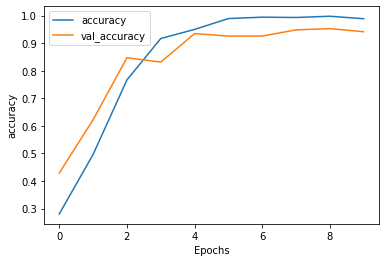

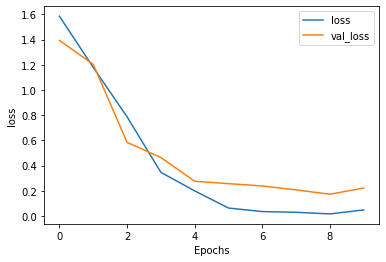

In [24]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

**Prediction**

In [25]:
txt = ["house prices show slight increase prices of homes in the uk rose a seasonally adjusted 0.5% in february  says the nationwide building society.  the figure means the annual rate of increase in the uk is down to 10.2%  the lowest rate since june 2001. the annual rate has halved since august last year  as interest rises have cooled the housing market. at the same time  the number of mortgage approvals fell in january to a near 10-year low  official bank of england figures have shown.  nationwide said that in january house prices went up by 0.4% on the month and by 12.6% on a year earlier.  we are not seeing the market collapsing in the way some had feared   said nationwide economist alex bannister. there have been a number of warnings that the uk housing market may be heading for a downturn after four years of strong growth to 2004. in november  barclays  which owns former building society the woolwich  forecast an 8% fall in property prices in 2005  followed by further declines in 2006 and 2007. and last summer  economists at pricewaterhousecoopers (pwc) warned house prices were overvalued and could fall by between 10% and 15% by 2009.  the price of an average uk property now stands at £152 879. homeowners now expect house prices to rise by 1% over the next six months  mr bannister said. he said if the growth continued at this level then the bank of england may increase interest rates from their current 4.75%.   i think the key is what the bank expects to happen to the housing market. we always thought we would see a small rise  they thought they would see a small decline.  house prices have risen 0.9% this year  nationwide said  and if this pace of increase persists  prices would rise by just under 6% in the year to december. this is slightly above the 0-5% range nationwide predicts.  further evidence of a slowdown in the housing market emerged from bank of england lending figures released on tuesday. new mortgage loans in january fell to 79 000 from 82 000 in december  the bank said. the past few months have seen approvals fall to levels last seen in 1995. the bank revealed that 48 000 fewer mortgages were approved in january than for the same month in 2004. overall  mortgage lending rose by £7.2bn in january  marginally up on the £7.1bn rise in december."]

seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
labels = ['sport', 'bussiness', 'politics', 'tech', 'entertainment'] #orig

print(pred)
print(np.argmax(pred))
print(labels[np.argmax(pred)-1])

[[4.0198971e-05 2.2958098e-04 9.9845874e-01 4.9865193e-04 4.9954175e-04
  2.7331625e-04]]
2
bussiness


In [0]:
|